https://matheusfacure.github.io/python-causality-handbook/10-Matching.html

In [2]:
data_path = '../../Python_Scripts/python-causality-handbook/causal-inference-for-the-brave-and-true/'

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Matching example

In [104]:
med = pd.read_csv(data_path + "./data/medicine_impact_recovery.csv")
med_ori = med.copy()
med.head()

,sex,age,severity,medication,recovery
0,0,35.049134,0.887658,1,31
1,1,41.580323,0.899784,1,49
2,1,28.127491,0.486349,0,38
3,1,36.375033,0.323091,0,35
4,0,25.091717,0.209006,0,15


In [105]:
# scale features
X = ["severity", "age", "sex"]
y = "recovery"

med = med.assign(**{f: (med[f] - med[f].mean())/med[f].std() for f in X})
med.head()

,sex,age,severity,medication,recovery
0,-0.996980,0.280787,1.459800,1,31
1,1.002979,0.865375,1.502164,1,49
2,1.002979,-0.338749,0.057796,0,38
3,1.002979,0.399465,-0.512557,0,35
4,-0.996980,-0.610473,-0.911125,0,15


use the K-Nearest neighbor regression with `k=1` as a trick match each treatment with a control and a control with a treatment

In [106]:
from sklearn.neighbors import KNeighborsRegressor

treated = med.query("medication==1")
untreated = med.query("medication==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[y])

predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=mt0.predict(treated[X])),
    
    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[X]))
])

predicted.head()

,sex,age,severity,medication,recovery,match
0,-0.996980,0.280787,1.459800,1,31,39.0
1,1.002979,0.865375,1.502164,1,49,52.0
7,-0.996980,1.495134,1.268540,1,38,46.0
10,1.002979,-0.106534,0.545911,1,34,45.0
16,-0.996980,0.043034,1.428732,1,30,39.0


Estimator: 
$
\hat{ATE} = \frac{1}{N} \sum^N_{i=0} (2T_i - 1)\big(Y_i - Y_{jm}(i)\big)
$ where $(2T_i - 1)$ is for adjusting the sign (Treatment - control). __This estimator is baised__

After controlling for confounder, medication reduces hospital stay by 1 day. However, __this estimator is baised__

In [107]:
np.mean((2*predicted["medication"] - 1)*(predicted["recovery"] - predicted["match"]))

-0.9954

Recall that if we don't control for confounding variables, medications somehow prolong recovery by 17 days. Draper 007
had a similar example of smoking and mortality if age is not blocked.

In [108]:
np.mean(predicted.query('medication == 1')['recovery']) - np.mean(predicted.query('medication == 0')['recovery'])

16.895799546498726

In [109]:
import statsmodels.formula.api as smf
smf.ols("recovery ~ medication", data=predicted).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,21.6761,0.121,178.865,0.000,21.439,21.914
medication,16.8958,0.206,82.033,0.000,16.492,17.300


In [110]:
import statsmodels.formula.api as smf
predicted = predicted.assign(recovery_std = lambda x: (x['recovery'] - x['recovery'].mean())/x['recovery'].std())
smf.ols("recovery_std ~ medication", data=predicted).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3651,0.008,-48.267,0.000,-0.380,-0.350
medication,1.0547,0.013,82.033,0.000,1.029,1.080


In [111]:
np.mean(predicted.query('medication == 1')['recovery_std']) - np.mean(predicted.query('medication == 0')['recovery_std'])

1.0546584823348348

In [112]:
predicted.groupby('medication').size()

medication
0    13076
1     6924
dtype: int64

### (Selection) Bias correction
__The above estimator $\hat{ATE}$:  \
Outcome for treated - Outcome for untreated = [Outcome for treated - Outcome for treated if not treated] + [Outcome for treated if not treated - Outcome for untreated]
 = Treatment Effect + Selection Bias__
 
 Therefore we need to substract the __Selection Bias__

Bias: $
E[\sqrt{N_1}(\hat{ATET} - ATET)] = E[\sqrt{N_1}(\mu_0(X_i) - \mu_0(X_j(i)))] 
$ = __E[counterfactual(treated if untreated) - matched_factual (untreated)]__

Now, $\mu_0(X_i) - \mu_0(X_j(i))$ is not so simple to understand, so let's look at it more carefully. $\mu_0(X_i)$ is the outcome Y value of a treated unit $i$ had it not been treated. So, it is the counterfactual outcome $Y_0$ for unit i. $\mu_0(X_j(i))$ is the outcome of the untreated unit $j$ that is the match of unit $i$. So, it is also the $Y_0$ , but for unit $j$ now. Only this time, it is a factual outcome, because $j$ is in the non treated group. Now, because $j$ and $i$ are only similar, but not the same, this will likely not be zero. In other words, $X_i \approx X_j $. So, $Y_{0i} \approx Y_{0j} $. 

As we increase the sample size, there will be more units to match, so the difference between unit $i$ and its match $j$ will also get smaller. But this difference converges to zero slowly. As a result $E[\sqrt{N_1}(\mu_0(X_i) - \mu_0(X_j(i)))]$ may not converge to zero, because the $\sqrt{N_1}$ grows faster than $(\mu_0(X_i) - \mu_0(X_j(i)))$ diminishes.

Bias arises when the matching discrepancies are huge. Fortunately, we know how to correct it. Each observation contributes $(\mu_0(X_i) - \mu_0(X_j(i)))$ to the bias so all we need to do is subtract this quantity from each matching comparison in our estimator. To do so, we can replace $\mu_0(X_j(i))$ with some sort of estimate of this quantity $\hat{\mu_0}(X_j(i))$, which can be obtained with models like linear regression. This updates the ATET estimator to the following equation

$
\hat{ATET} = \frac{1}{N_1}\sum \big((Y_i - Y_{j(i)}) - (\hat{\mu_0}(X_i) - \hat{\mu_0}(X_{j(i)}))\big)
$

where $\hat{\mu_0}(x)$ is some estimative of $E[Y|X, T=0]$, like a linear regression fitted only on the untreated sample.

In [115]:
from sklearn.linear_model import LinearRegression

# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(untreated[X], untreated[y])
ols1 = LinearRegression().fit(treated[X], treated[y])

# find the units that match to the treated, [0] is value, [1] is the matched index
treated_match_index = mt0.kneighbors(treated[X], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd, [0] is value, [1] is the matched index
untreated_match_index = mt1.kneighbors(untreated[X], n_neighbors=1)[1].ravel()

predicted = pd.concat([
    (treated
     # find the Y match on the other group
     .assign(match=mt0.predict(treated[X])) 
     
     # build the bias correction term 
     
     ## (predicted) treated as if untreated - (predicted) matched treated (for the untreated)
     ## out of sample - in_sample
     .assign(bias_correct=ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X]))),
    
    (untreated
     .assign(match=mt1.predict(untreated[X]))
     ## (predicted) untreated as if treated - (predicted) matched untreated (for the treated)
     .assign(bias_correct=ols1.predict(untreated[X]) - ols1.predict(treated.iloc[untreated_match_index][X])))
])

predicted2 = pd.concat([
    (treated
     # find the Y match on the other group
     .assign(match=mt0.predict(treated[X])) 
     
     # build the bias correction term 
     
     ## (predicted) treated as if untreated - (predicted) matched treated (for the untreated)
     .assign(bias_correct=ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X]))),
    
    (untreated
     .assign(match=mt1.predict(untreated[X]))
     
     ## (predicted) treated as if untreated - (predicted) matched treated (for the untreated)
     .assign(bias_correct=ols1.predict(treated.iloc[untreated_match_index][X]) - ols1.predict(untreated[X])))
])

predicted.head()

,sex,age,severity,medication,recovery,match,bias_correct
0,-0.996980,0.280787,1.459800,1,31,39.0,4.404034
1,1.002979,0.865375,1.502164,1,49,52.0,12.915348
7,-0.996980,1.495134,1.268540,1,38,46.0,1.871428
10,1.002979,-0.106534,0.545911,1,34,45.0,-0.496970
16,-0.996980,0.043034,1.428732,1,30,39.0,2.610159


After bias correction, the medication effect is more obvious, which reduces hospital stays by 7 days

In [10]:
np.mean((2*predicted["medication"] - 1)*((predicted["recovery"] - predicted["match"])-predicted["bias_correct"]))

-7.362660906141352

In [11]:
d1 = predicted.query('medication == 1')
d0 = predicted.query('medication == 0')

In [12]:
np.concatenate((d1['recovery'] - d1['match'] - d1['bias_correct'], d0['match'] - d0['recovery'] +  d0['bias_correct'])).mean()

-7.362660906141408

In [117]:
d11 = predicted2.query('medication == 1')
d00 = predicted2.query('medication == 0')

In [118]:
np.concatenate((d11['recovery'] - d11['match'] - d11['bias_correct'], d00['match'] - d00['recovery'] -  d00['bias_correct'])).mean()

-7.362660906141408

__bias correction could also be obtained through the doubly robust estimator__

### Using package

In [13]:
!pip3 install causalinference

In [14]:
from causalinference import CausalModel

cm = CausalModel(
    Y=med["recovery"].values, 
    D=med["medication"].values, 
    X=med[["severity", "age", "sex"]].values ## recall .values is the same as .to_numpy()
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)

C:\Users\josep\anaconda3\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -7.709      0.609    -12.649      0.000     -8.903     -6.514
           ATC     -6.665      0.246    -27.047      0.000     -7.148     -6.182
           ATT     -9.679      1.693     -5.717      0.000    -12.997     -6.361



Here ATE, ATC, and ATT standfor, respectively, average treatment effect, average treatment effect for the controls, and average treatment effect for the treated.

## Propensity score method

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
model = LogisticRegression(C=1e5).fit(med[["severity", "age", "sex"]].values, med["medication"].values)

In [18]:
pos = model.predict_proba(med[["severity", "age", "sex"]].values)[:,1] ## probability of receiving the treatment

In [19]:
med['pos'] = pos
med_ori['pos'] = pos

__We can't use this method since propensity scores are very unbalanced__

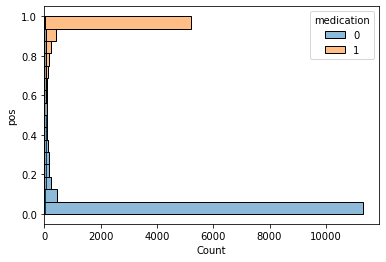

In [20]:
sns.histplot(data = med, y='pos',hue='medication');

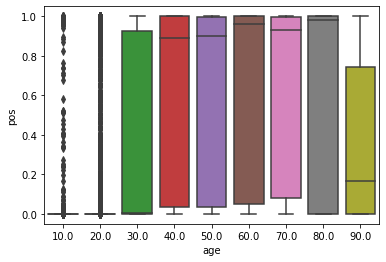

In [21]:
med_ori['age'] = np.round(med_ori['age'],-1)

sns.boxplot(data = med_ori, y='pos',x='age');

In [22]:
w1 = 1/med.query('medication==1')['pos']
w0 = 1/(1-med.query('medication==0')['pos'])
## divide by the original sample size!!!
sum(w1 * med.query('medication==1')['recovery'])/med.shape[0] - \
sum((w0 * med.query('medication==0')['recovery']))/med.shape[0]

-2.63643186081017

__Very unbalanced, propensity score will lead to more unbalanceness__

see paper
https://gking.harvard.edu/publications/why-propensity-scores-should-not-be-used-formatching

In [23]:
print(sum(w1) ,sum(w0), med.shape[0]) ## they should be approximately equal for propensity score to work properly

10051.065813151487 15977.97153917509 20000


In [24]:
weight = ((med["medication"]-med["pos"]) /
          (med["pos"]*(1-med["pos"])))
np.mean(weight * med["recovery"])

-2.6364318608101804

## Doubly Robust Estimators

If only one of them is correct, we get similar result as if both were correct, except the bootstrap variance is higher.

In [25]:
data = pd.read_csv(data_path + "./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,5,1,2,0,1,-0.462945,0.652608,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,5,13,1,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,5,2,2,1,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4488,67,0,0.358336,6,14,1,0,4,-1.115337,1.053089,0.315755,0.054586,1.862187
2637,16,1,1.360920,6,4,1,0,1,-0.538975,1.433826,-0.033161,-0.982274,1.591641


In [26]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [27]:
temp_name = 'medication'

med.query(f'{temp_name}==1')

,sex,age,severity,medication,recovery,pos
0,-0.996980,0.280787,1.459800,1,31,0.998795
1,1.002979,0.865375,1.502164,1,49,0.999985
7,-0.996980,1.495134,1.268540,1,38,0.993040
10,1.002979,-0.106534,0.545911,1,34,0.879452
16,-0.996980,0.043034,1.428732,1,30,0.998367
...,...,...,...,...,...,...
19982,1.002979,0.444150,1.667773,1,48,0.999997
19988,1.002979,-0.736709,0.227483,1,28,0.258804
19989,1.002979,1.002589,0.326361,1,39,0.489000
19993,1.002979,1.627845,0.920818,1,49,0.996342


In [28]:
def doubly_robust(df, X, T, Y, n_runs = 1, bootstrap = False):
    out = np.zeros(n_runs)
    if bootstrap:
        df = df.sample(frac=1,replace=True)
    for i in range(n_runs):
        ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
        mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
        mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
        out[i] = np.mean(df[T]*(df[Y] - mu1)/ps + mu1) - np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    return(out)

In [29]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y,1)

array([0.38822161])

In [30]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates).reshape(-1)

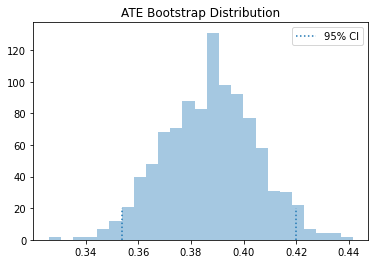

In [37]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## Example where Propensity score works

In [4]:
data = pd.read_csv(data_path + "./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,5,1,2,0,1,-0.462945,0.652608,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,5,13,1,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,5,2,2,1,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4488,67,0,0.358336,6,14,1,0,4,-1.115337,1.053089,0.315755,0.054586,1.862187
2637,16,1,1.360920,6,4,1,0,1,-0.538975,1.433826,-0.033161,-0.982274,1.591641


In [5]:
data.groupby('intervention').size()

intervention
0    7007
1    3384
dtype: int64

__counfounding variable__: obviously, students have higher expectation will visit the seminar

In [14]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

In [13]:
data.groupby("intervention")["achievement_score"].mean()

intervention
0   -0.153803
1    0.318469
Name: achievement_score, dtype: float64

__difference of Standardized variable is deviation__:

For example normal distribution of 1.96 and 0 and 2 std deviation.

In [15]:
data['achievement_score'].describe() ## the score is standardized

count    1.039100e+04
mean     1.324073e-16
std      1.000000e+00
min     -3.111431e+00
25%     -7.033152e-01
50%     -3.449486e-02
75%      6.724723e-01
max      3.563639e+00
Name: achievement_score, dtype: float64

<AxesSubplot:xlabel='achievement_score', ylabel='Count'>

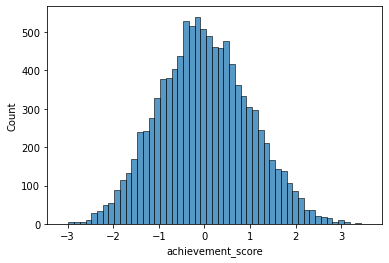

In [17]:
sns.histplot(data['achievement_score'])

In [59]:
import statsmodels.formula.api as smf
smf.ols("achievement_score ~ (intervention)", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


In [94]:
n = 10000
mask = np.random.choice(2,size=n)
y = TE * mask + np.random.normal(size = n)
xy_df = pd.DataFrame({"y":y,"x":mask})

In [95]:
smf.ols('y~x',data = xy_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0182,0.014,-1.275,0.202,-0.046,0.010
x,5.0256,0.020,248.908,0.000,4.986,5.065


In [101]:
np.mean(xy_df.query('x==1')['y']) - np.mean(xy_df.query('x==0')['y'])

5.025587889019991

In [96]:
xy_df = xy_df.assign(y_sd = lambda x: (x['y'] - x['y'].mean())/x['y'].std())

In [97]:
smf.ols('y_sd~x',data = xy_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.9299,0.005,-176.198,0.000,-0.940,-0.920
x,1.8558,0.007,248.908,0.000,1.841,1.870


In [100]:
np.mean(xy_df.query('x==1')['y_sd']) - np.mean(xy_df.query('x==0')['y_sd'])

1.8557654512264934